In [1]:
!pip install gdown tensorflow scikit-learn matplotlib Pillow numpy

In [2]:
import gdown
import zipfile

gdown.download("https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ", "dataset.zip", quiet=False)
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extraído exitosamente.")


Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=70213d28-58a4-4a46-8f00-d72fb2504f89
To: /content/dataset.zip
100%|██████████| 363M/363M [00:07<00:00, 48.8MB/s]


Dataset extraído exitosamente.


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, Add, Dropout,
    BatchNormalization, Activation, GlobalAveragePooling2D, Rescaling, 
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import ssl

# Desactiva la verificación SSL para evitar errores de descarga
ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# Configuración global
batch_size = 64  # Tamaño del batch para entrenamiento
image_height = 64  # Altura de las imágenes
image_width = 64   # Anchura de las imágenes
target_size = (image_height, image_width)  # Tamaño de entrada

class SceneClassifier:
    """Clasificador de escenas naturales con redes neuronales."""

    def __init__(self, train_dir, test_dir):
        """
        Inicializa la clase con los parámetros necesarios.

        Args:
            train_dir (str): Ruta del directorio de entrenamiento.
            test_dir (str): Ruta del directorio de prueba.
        """
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.models = {}
        self.history = {}

    def load_data(self):
        """Carga y preprocesa los datos de entrenamiento y prueba."""
        try:
            train_datagen = ImageDataGenerator(rescale=1.0 / 255)
            test_datagen = ImageDataGenerator(rescale=1.0 / 255)

            self.train_generator = train_datagen.flow_from_directory(
                self.train_dir, target_size=self.target_size,
                batch_size=self.batch_size, class_mode='categorical'
            )
            self.test_generator = test_datagen.flow_from_directory(
                self.test_dir, target_size=self.target_size,
                batch_size=self.batch_size, class_mode='categorical'
            )
            print("Datos cargados exitosamente.")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    def build_dense_model(self):
        """Construye un modelo denso mejorado con regularización."""
        try:
            model = Sequential([
                Flatten(input_shape=(*self.target_size, 3)),
                Dense(512, activation='relu', kernel_initializer='he_normal', 
                      kernel_regularizer='l2'),
                Dropout(0.5),
                Dense(256, activation='relu', kernel_initializer='he_normal', 
                      kernel_regularizer='l2'),
                Dropout(0.4),
                Dense(128, activation='relu', kernel_initializer='he_normal', 
                      kernel_regularizer='l2'),
                Dense(6, activation='softmax')
            ])
            self._compile_model(model, 'dense')
            print("Modelo denso construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo denso: {e}")

    def build_cnn_model(self):
        """Construye un modelo CNN mejorado con augmentación y regularización."""
        try:
            model = Sequential([
                Rescaling(1. / 255, input_shape=(*self.target_size, 3)),
                RandomFlip("horizontal"),
                RandomRotation(0.1),
                RandomZoom(0.1),

                Conv2D(32, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                BatchNormalization(),

                Conv2D(64, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                BatchNormalization(),

                Dropout(0.3),

                Conv2D(128, (3, 3), activation='relu'),
                MaxPooling2D((2, 2)),
                BatchNormalization(),

                Flatten(),

                Dense(128, activation='relu', kernel_initializer='he_normal'),
                Dropout(0.5),

                Dense(6, activation='softmax')
            ])
            self._compile_model(model, 'cnn')
            print("Modelo CNN construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo CNN: {e}")

    def _compile_model(self, model, name):
        """Compila el modelo con las métricas necesarias."""
        try:
            model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', Precision(name='precision'),
                         Recall(name='recall'), AUC(name='auc')]
            )
            self.models[name] = model
        except Exception as e:
            print(f"Error al compilar el modelo {name}: {e}")

    def train(self, model_name, epochs=5):
        """Entrena un modelo con EarlyStopping."""
        try:
            model = self.models[model_name]
            early_stop = EarlyStopping(
                monitor='val_loss', patience=30, restore_best_weights=True
            )

            history = model.fit(
                self.train_generator, epochs=epochs,
                validation_data=self.test_generator, callbacks=[early_stop]
            )
            self.history[model_name] = history
        except Exception as e:
            print(f"Error durante el entrenamiento: {e}")

    def predict(self, model_name, image_path):
        """Realiza una predicción sobre una imagen."""
        try:
            if model_name not in self.models:
                raise ValueError(f"Modelo no entrenado: {model_name}")

            original_img = Image.open(image_path)
            img = original_img.resize(self.target_size)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            model = self.models[model_name]
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            class_indices = self.train_generator.class_indices
            class_labels = {v: k for k, v in class_indices.items()}
            predicted_label = class_labels[predicted_class]

            plt.imshow(original_img)
            plt.title(f"Clase predicha: {predicted_label}", fontsize=18, color='blue')
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error durante la predicción: {e}")

# Cargar los dataset

In [7]:
classifier = SceneClassifier(
    train_dir='seg_train/seg_train',
    test_dir='seg_test/seg_test',
)
classifier.load_data()
epochs = 100

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Datos cargados exitosamente.


# Construir los modelos de capas Densa

In [8]:
model_name = 'dense'
classifier.build_dense_model()
classifier.train(model_name, epochs=epochs)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/3.jpg'
classifier.predict('dense', imagen)

/Users/pepeargentoo/AAII-2/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/pepeargentoo/AAII-2/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Modelo denso construido exitosamente.
Epoch 1/100
 65/220 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.1882 - auc: 0.5258 - loss: 19.1113 - precision: 0.1992 - recall: 0.1153

KeyboardInterrupt: 

# Construir los modelos de CNN

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.5437 - auc: 0.8290 - loss: 2.3980 - precision: 0.6375 - recall: 0.3940 - val_accuracy: 0.6657 - val_auc: 0.9227 - val_loss: 0.9086 - val_precision: 0.7074 - val_recall: 0.6020
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8131 - auc: 0.9709 - loss: 0.5376 - precision: 0.8620 - recall: 0.7521 - val_accuracy: 0.7087 - val_auc: 0.9372 - val_loss: 0.8050 - val_precision: 0.7644 - val_recall: 0.6533
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9132 - auc: 0.9927 - loss: 0.2778 - precision: 0.9367 - recall: 0.8854 - val_accuracy: 0.7353 - val_auc: 0.9373 - val_loss: 0.8491 - val_precision: 0.7713 - val_recall: 0.6960
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9684 - auc: 0.9984 - loss: 0.1236 - precision: 0.9749 - recall: 0.9584 - val_accuracy: 0.7380 - val_auc: 0.9361 - val_loss: 0.8872 - val_precision: 0.7594 - val_recall: 0.7123
Epoch 5/100
439/439 ━━━━━━━━━━━━

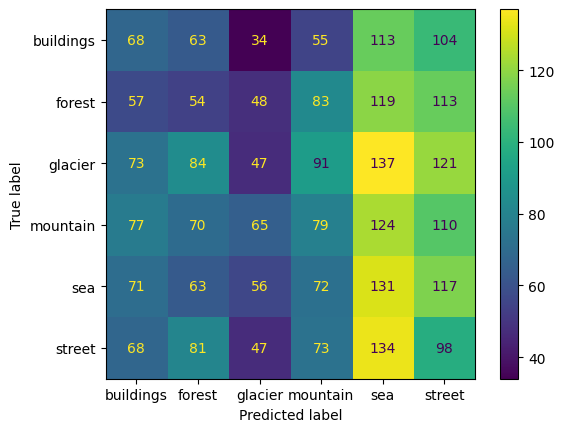

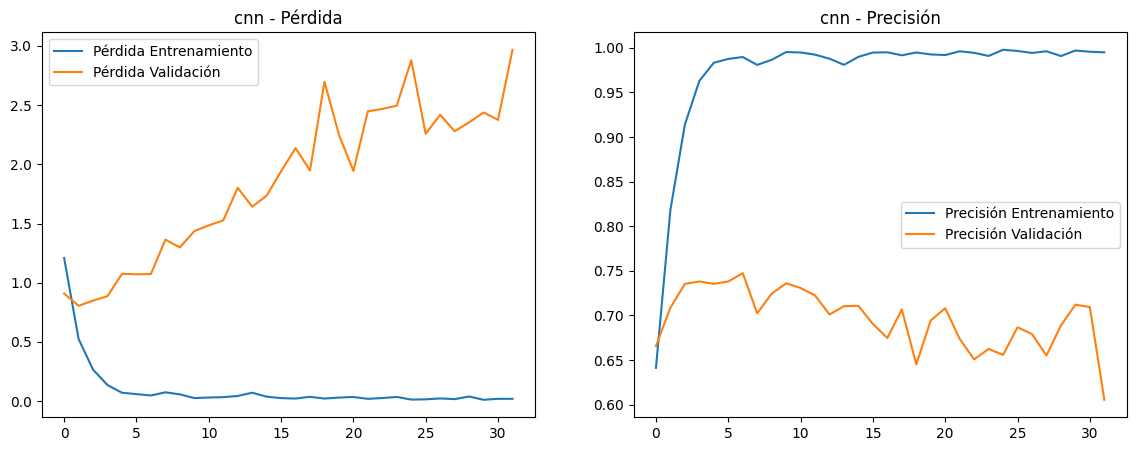

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


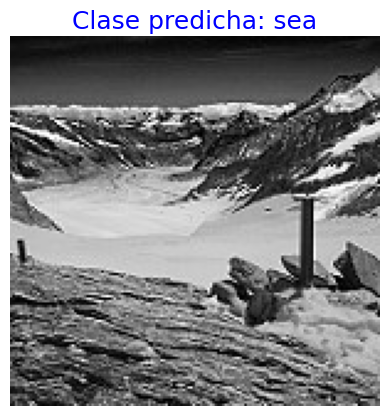

In [13]:
model_name = 'cnn'
classifier.build_cnn_model()
classifier.train(model_name, epochs=epochs)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/11.jpg'
classifier.predict(model_name, imagen)

# Construir los modelos de Red residual

Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 39s 71ms/step - accuracy: 0.4373 - auc: 0.7146 - loss: 13.5229 - precision: 0.4428 - recall: 0.4295 - val_accuracy: 0.5747 - val_auc: 0.8482 - val_loss: 2.0867 - val_precision: 0.5869 - val_recall: 0.5603
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.7090 - auc: 0.9235 - loss: 1.1247 - precision: 0.7250 - recall: 0.6914 - val_accuracy: 0.5840 - val_auc: 0.8567 - val_loss: 1.8410 - val_precision: 0.6067 - val_recall: 0.5640
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.8423 - auc: 0.9733 - loss: 0.5269 - precision: 0.8581 - recall: 0.8308 - val_accuracy: 0.5673 - val_auc: 0.8330 - val_loss: 2.3254 - val_precision: 0.5797 - val_recall: 0.5563
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.9001 - auc: 0.9856 - loss: 0.3463 - precision: 0.9070 - recall: 0.8944 - val_accuracy: 0.6137 - val_auc: 0.8608 - val_loss: 2.1731 - val_precision: 0.6253 - val_recall: 0.6040
Epoch 5/100
439/439

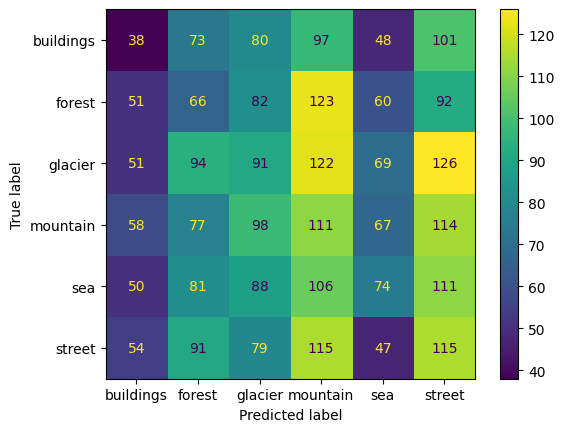

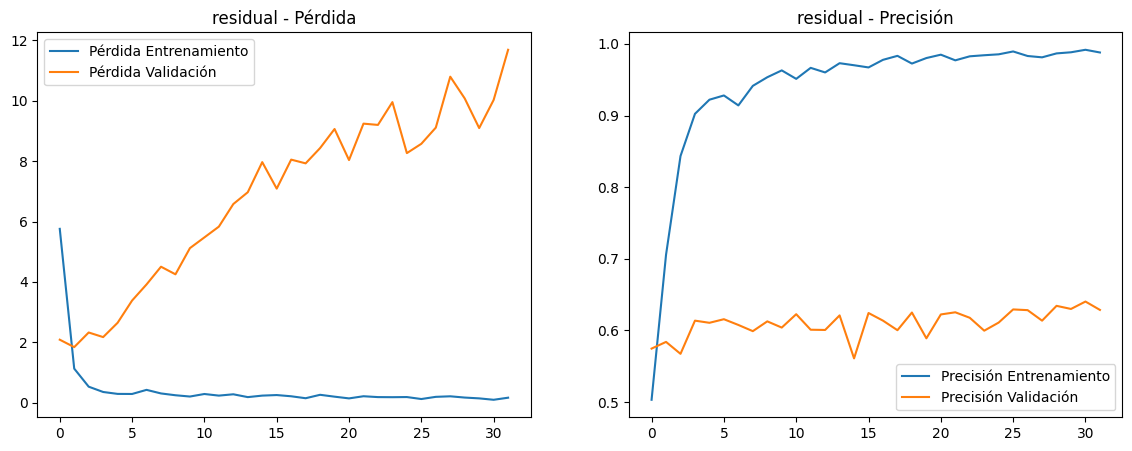

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


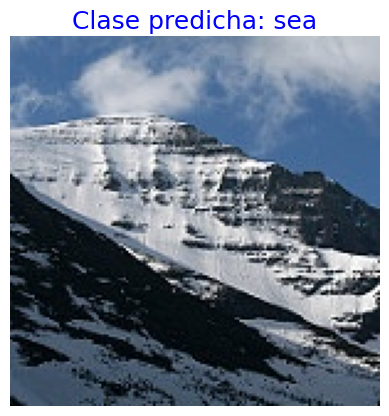

In [14]:
model_name = 'residual'
classifier.build_residual_model()
classifier.train(model_name, epochs=epochs)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/30.jpg'
classifier.predict(model_name, imagen)

# Construir los modelos a traves de tf learnigin

In [15]:
model_name = 'efficientnet'
classifier.build_transfer_model()
classifier.train(model_name, epochs=epochs)
classifier.evaluate(model_name)
classifier.plot_history(model_name)
imagen = 'seg_pred/seg_pred/69.jpg'
classifier.predict(model_name, imagen)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 73s 112ms/step - accuracy: 0.1701 - auc: 0.5005 - loss: 1.8074 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1750 - val_auc: 0.5193 - val_loss: 1.7904 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.1761 - auc: 0.5111 - loss: 1.7911 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1750 - val_auc: 0.5211 - val_loss: 1.7902 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.1814 - auc: 0.5145 - loss: 1.7909 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1750 - val_auc: 0.5211 - val_loss: 1.7901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.1869 - auc: 0.5194 - loss: 1.7899 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0

KeyboardInterrupt: 